# Etape 5 - Visualisations Matplotlib

**Objectif** : Creer des graphiques professionnels pour le rapport annuel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

OUTPUT_DIR = "../output"
FIGURES_DIR = f"{OUTPUT_DIR}/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

In [2]:
# Charger les donnees
df = pd.read_csv(f"{OUTPUT_DIR}/pollution_meteo_clean.csv", parse_dates=['datetime_hour'])

# Ajouter colonnes temporelles
df['date'] = df['datetime_hour'].dt.date
df['hour'] = df['datetime_hour'].dt.hour
df['day_of_week'] = df['datetime_hour'].dt.dayofweek
df['month'] = df['datetime_hour'].dt.month

# Colonne de valeur
value_col = 'value_mean' if 'value_mean' in df.columns else 'value'

print(f"Donnees chargees: {len(df):,} lignes")
print(f"Periode: {df['datetime_hour'].min()} -> {df['datetime_hour'].max()}")

Donnees chargees: 1,176,727 lignes
Periode: 2024-01-01 00:00:00 -> 2024-06-30 23:00:00


## 5.1 Evolution temporelle des PM2.5 et PM10

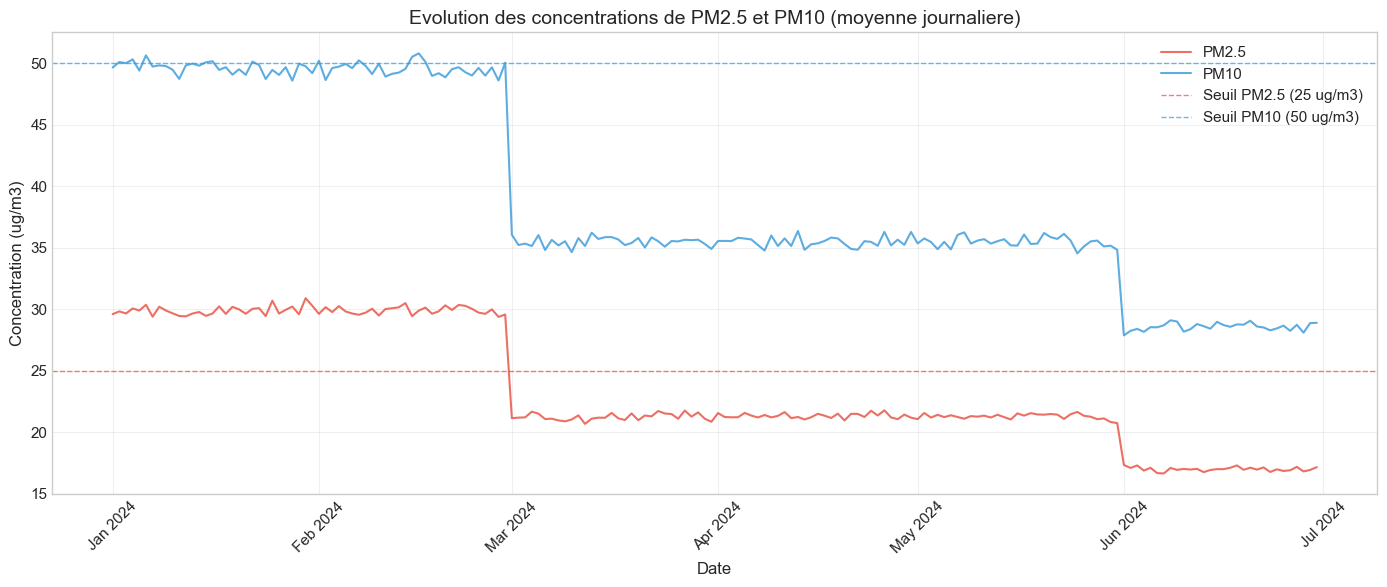

Figure sauvegardee: ../output/figures/01_evolution_pm.png


In [3]:
# Agreger par jour pour PM2.5 et PM10
df_pm = df[df['pollutant'].isin(['PM2.5', 'PM10'])].copy()
df_pm['date'] = pd.to_datetime(df_pm['date'])

daily_pm = df_pm.groupby(['date', 'pollutant'])[value_col].mean().unstack()

# Seuils
SEUIL_PM25 = 25
SEUIL_PM10 = 50

# Figure
fig, ax = plt.subplots(figsize=(14, 6))

# Tracer les courbes
ax.plot(daily_pm.index, daily_pm['PM2.5'], label='PM2.5', color='#E74C3C', linewidth=1.5, alpha=0.8)
ax.plot(daily_pm.index, daily_pm['PM10'], label='PM10', color='#3498DB', linewidth=1.5, alpha=0.8)

# Ajouter les seuils
ax.axhline(y=SEUIL_PM25, color='#E74C3C', linestyle='--', linewidth=1, alpha=0.7, label=f'Seuil PM2.5 ({SEUIL_PM25} ug/m3)')
ax.axhline(y=SEUIL_PM10, color='#3498DB', linestyle='--', linewidth=1, alpha=0.7, label=f'Seuil PM10 ({SEUIL_PM10} ug/m3)')

# Mise en forme
ax.set_xlabel('Date')
ax.set_ylabel('Concentration (ug/m3)')
ax.set_title('Evolution des concentrations de PM2.5 et PM10 (moyenne journaliere)')
ax.legend(loc='upper right')

# Format des dates
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Grille
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/01_evolution_pm.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/01_evolution_pm.png")

## 5.2 Distribution des concentrations de NO2 par ville (Boxplot)

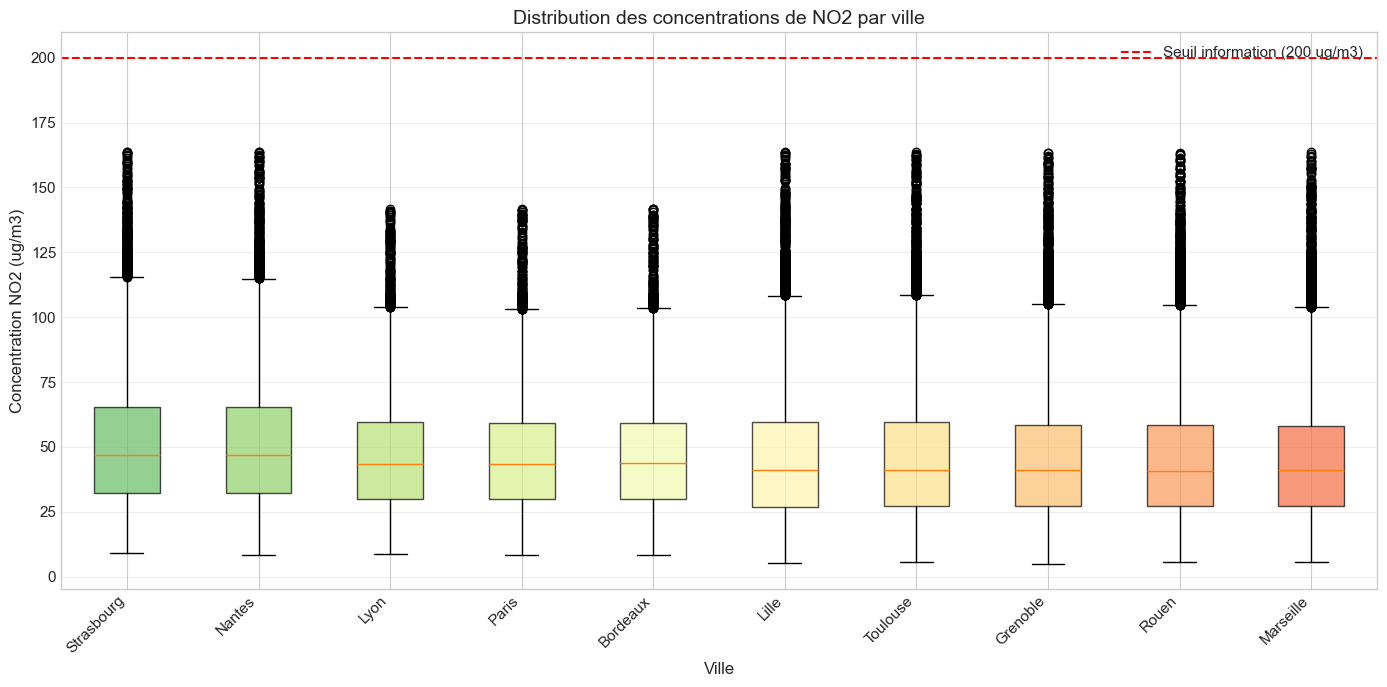

Figure sauvegardee: ../output/figures/02_boxplot_no2_ville.png


In [4]:
# Filtrer NO2
df_no2 = df[df['pollutant'] == 'NO2'].copy()

# Ordre des villes par moyenne decroissante
city_order = df_no2.groupby('city')[value_col].mean().sort_values(ascending=False).index.tolist()

# Preparer les donnees pour boxplot
data_boxplot = [df_no2[df_no2['city'] == city][value_col].dropna().values for city in city_order]

# Figure
fig, ax = plt.subplots(figsize=(14, 7))

# Boxplot
bp = ax.boxplot(data_boxplot, labels=city_order, patch_artist=True)

# Couleurs
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(city_order)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Seuil d'information
ax.axhline(y=200, color='red', linestyle='--', linewidth=1.5, label='Seuil information (200 ug/m3)')

# Mise en forme
ax.set_xlabel('Ville')
ax.set_ylabel('Concentration NO2 (ug/m3)')
ax.set_title('Distribution des concentrations de NO2 par ville')
ax.legend(loc='upper right')

plt.xticks(rotation=45, ha='right')
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/02_boxplot_no2_ville.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/02_boxplot_no2_ville.png")

## 5.3 Heatmap des concentrations moyennes par heure et jour de semaine

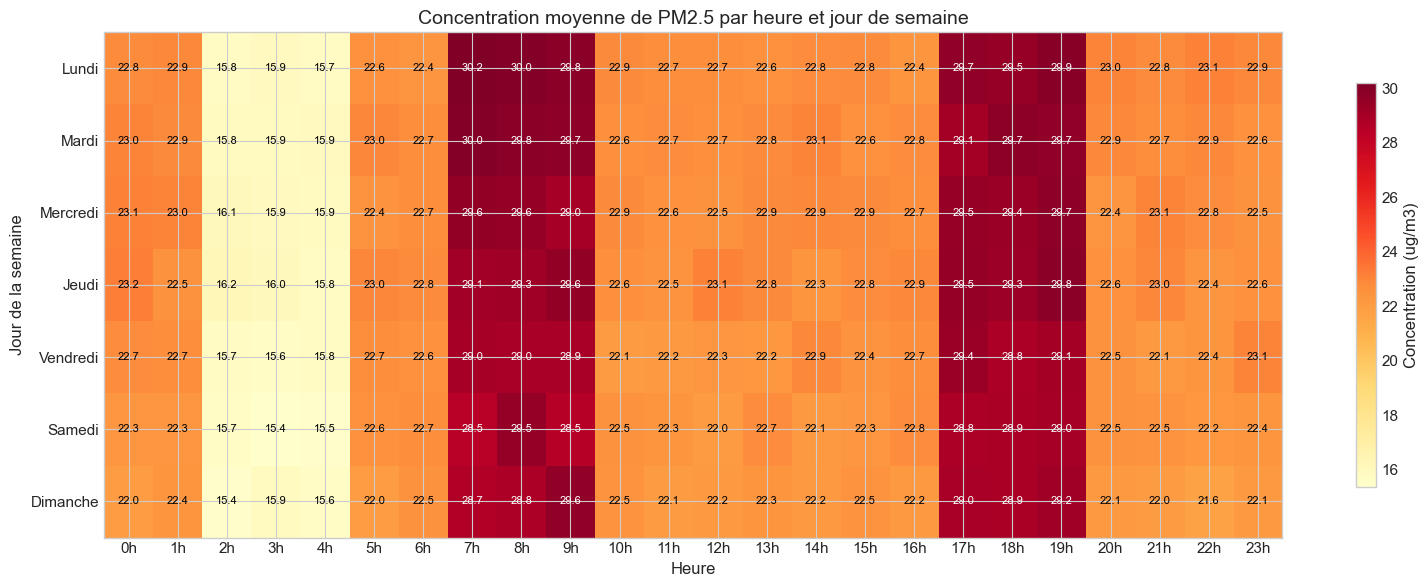

Figure sauvegardee: ../output/figures/03_heatmap_heure_jour.png


In [5]:
# Choisir un polluant (PM2.5 par defaut)
pollutant_heatmap = 'PM2.5'
df_heatmap = df[df['pollutant'] == pollutant_heatmap].copy()

# Pivot: jour de semaine x heure
pivot_heatmap = df_heatmap.pivot_table(
    values=value_col,
    index='day_of_week',
    columns='hour',
    aggfunc='mean'
)

# Noms des jours
day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

# Figure
fig, ax = plt.subplots(figsize=(16, 6))

# Heatmap
im = ax.imshow(pivot_heatmap.values, cmap='YlOrRd', aspect='auto')

# Axes
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h}h' for h in range(24)])
ax.set_yticks(range(7))
ax.set_yticklabels(day_names)

# Colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Concentration (ug/m3)')

# Annotations
for i in range(len(day_names)):
    for j in range(24):
        value = pivot_heatmap.values[i, j]
        if not np.isnan(value):
            text_color = 'white' if value > pivot_heatmap.values.mean() else 'black'
            ax.text(j, i, f'{value:.1f}', ha='center', va='center', 
                   color=text_color, fontsize=8)

ax.set_xlabel('Heure')
ax.set_ylabel('Jour de la semaine')
ax.set_title(f'Concentration moyenne de {pollutant_heatmap} par heure et jour de semaine')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/03_heatmap_heure_jour.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/03_heatmap_heure_jour.png")

## 5.4 Scatter plot Temperature vs Ozone avec regression

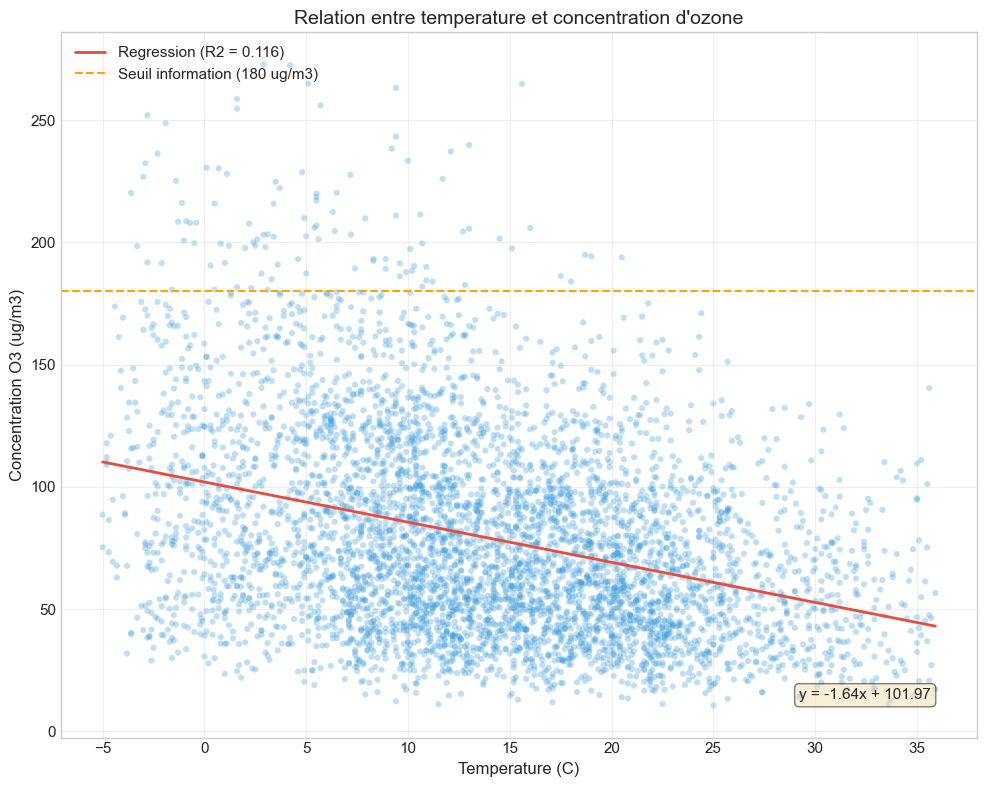

Figure sauvegardee: ../output/figures/04_scatter_temp_ozone.png

Correlation temperature/ozone: R = -0.340, R2 = 0.116
p-value: 1.45e-135


In [6]:
# Filtrer O3 avec donnees meteo
df_o3 = df[(df['pollutant'] == 'O3') & (df['temperature_c'].notna())].copy()

# Echantillonner si trop de points
if len(df_o3) > 5000:
    df_o3_sample = df_o3.sample(5000, random_state=42)
else:
    df_o3_sample = df_o3

# Regression lineaire
x = df_o3_sample['temperature_c'].values
y = df_o3_sample[value_col].values
mask = ~(np.isnan(x) | np.isnan(y))
x, y = x[mask], y[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line_x = np.linspace(x.min(), x.max(), 100)
line_y = slope * line_x + intercept

# Figure
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter
scatter = ax.scatter(x, y, alpha=0.3, c='#3498DB', s=20, edgecolors='none')

# Ligne de regression
ax.plot(line_x, line_y, color='#E74C3C', linewidth=2, 
        label=f'Regression (R2 = {r_value**2:.3f})')

# Seuil O3
ax.axhline(y=180, color='orange', linestyle='--', linewidth=1.5, 
           label='Seuil information (180 ug/m3)')

# Mise en forme
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Concentration O3 (ug/m3)')
ax.set_title('Relation entre temperature et concentration d\'ozone')
ax.legend(loc='upper left')

# Ajouter equation
equation = f'y = {slope:.2f}x + {intercept:.2f}'
ax.text(0.95, 0.05, equation, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/04_scatter_temp_ozone.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/04_scatter_temp_ozone.png")
print(f"\nCorrelation temperature/ozone: R = {r_value:.3f}, R2 = {r_value**2:.3f}")
print(f"p-value: {p_value:.2e}")

## 5.5 Evolution mensuelle par polluant (bar chart)

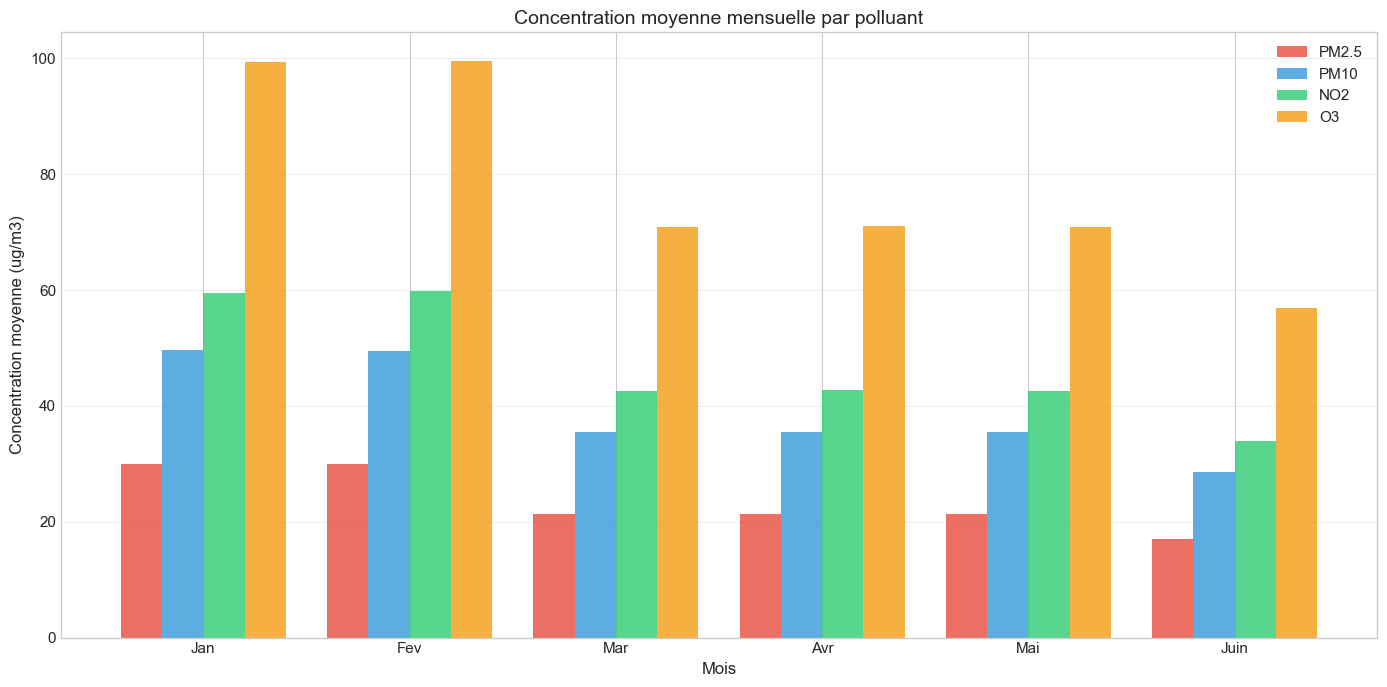

Figure sauvegardee: ../output/figures/05_barplot_mensuel.png


In [7]:
# Moyenne mensuelle par polluant
monthly_avg = df.groupby(['month', 'pollutant'])[value_col].mean().unstack()

# Selectionner les polluants principaux
main_pollutants = ['PM2.5', 'PM10', 'NO2', 'O3']
available = [p for p in main_pollutants if p in monthly_avg.columns]
monthly_avg = monthly_avg[available]

# Noms des mois
month_names = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aout', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg.index = [month_names[i-1] for i in monthly_avg.index]

# Figure
fig, ax = plt.subplots(figsize=(14, 7))

# Bar chart groupe
x = np.arange(len(monthly_avg.index))
width = 0.2
colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

for i, (pollutant, color) in enumerate(zip(available, colors)):
    ax.bar(x + i*width, monthly_avg[pollutant], width, label=pollutant, color=color, alpha=0.8)

# Mise en forme
ax.set_xlabel('Mois')
ax.set_ylabel('Concentration moyenne (ug/m3)')
ax.set_title('Concentration moyenne mensuelle par polluant')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(monthly_avg.index)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/05_barplot_mensuel.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/05_barplot_mensuel.png")

## 5.6 Resume des figures generees

In [8]:
# Lister les figures
figures = os.listdir(FIGURES_DIR)
figures = [f for f in figures if f.endswith('.png')]

print("Figures generees:")
for f in sorted(figures):
    filepath = os.path.join(FIGURES_DIR, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

Figures generees:
  01_evolution_pm.png (317.5 KB)
  02_boxplot_no2_ville.png (241.8 KB)
  03_heatmap_heure_jour.png (368.3 KB)
  04_scatter_temp_ozone.png (1274.0 KB)
  05_barplot_mensuel.png (116.3 KB)
